In [85]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pyAgrum as gum
import pyAgrum.lib.notebook as gnb
import pyAgrum.lib.image as gimg

from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.utils import shuffle

# Data preprocessing

In [65]:
data = pd.read_csv('./weather.csv')
df = data.iloc[:, 19: 30]
df["month"] = data.iloc[:, 1]
df.head()

,DE_BILT_cloud_cover,DE_BILT_wind_speed,DE_BILT_wind_gust,DE_BILT_humidity,DE_BILT_pressure,DE_BILT_global_radiation,DE_BILT_precipitation,DE_BILT_sunshine,DE_BILT_temp_mean,DE_BILT_temp_min,DE_BILT_temp_max,month
0,7,2.5,8.0,0.97,1.0240,0.11,0.10,0.0,6.1,3.5,8.1,1
1,8,3.7,9.0,0.97,1.0267,0.11,0.00,0.0,7.3,5.4,8.7,1
2,8,6.1,13.0,0.94,1.0203,0.11,0.45,0.0,8.4,6.4,9.6,1
3,7,3.8,15.0,0.94,1.0142,0.11,1.09,0.0,6.4,4.3,9.4,1
4,3,4.0,12.0,0.90,1.0183,0.48,0.00,6.5,4.4,1.4,7.4,1


In [66]:
df.isnull().sum()

DE_BILT_cloud_cover         0
DE_BILT_wind_speed          0
DE_BILT_wind_gust           0
DE_BILT_humidity            0
DE_BILT_pressure            0
DE_BILT_global_radiation    0
DE_BILT_precipitation       0
DE_BILT_sunshine            0
DE_BILT_temp_mean           0
DE_BILT_temp_min            0
DE_BILT_temp_max            0
month                       0
dtype: int64

In [67]:
bn_df = pd.DataFrame()

season_mapping = {
    12: 'Winter', 1: 'Winter', 2: 'Winter',
    3: 'Spring', 4: 'Spring', 5: 'Spring',
    6: 'Summer', 7: 'Summer', 8: 'Summer',
    9: 'Autumn', 10: 'Autumn', 11: 'Autumn'
}

bn_df['season'] = df['month'].map(season_mapping)
bn_df["cloud coverage"] = df["DE_BILT_cloud_cover"].apply(lambda x: (x / 8) * 100)# Map oktas to %
bn_df["humidity"] = df["DE_BILT_humidity"].apply(lambda x: x * 100)# Convert humidity from fraction of % to %
bn_df["pressure"] = df["DE_BILT_pressure"].apply(lambda x: x * 1000)
bn_df["rain"] = df["DE_BILT_precipitation"]
bn_df["temp"] = df["DE_BILT_temp_mean"]


In [68]:
bn_cat_df = pd.DataFrame()
bn_cat_df["season"] = bn_df['season']
bn_cat_df["pressure"] = bn_df["pressure"].apply(lambda x: "high" if x >= bn_df["pressure"].mean() else "low")
bn_cat_df["cloud coverage"] = bn_df["cloud coverage"].apply(lambda x: "high" if x >= 85 else "low")
bn_cat_df["temp"] = bn_df["temp"].apply(lambda x: "high" if x >= bn_df["temp"].mean() else "low")

labels = ['low', 'medium', 'high']

for col in ["humidity"]:
    quantiles = bn_df[col].quantile([0, 0.33, 0.66, 1.0])
    bn_cat_df[col] = pd.cut(bn_df[col], bins=quantiles, labels=labels, include_lowest=True)
    
bn_cat_df["rain"] = bn_df["rain"].apply(lambda x: "rain" if x > 0 else "no rain")

In [69]:
bn_cat_df.head()

,season,pressure,cloud coverage,temp,humidity,rain
0,Winter,high,high,low,high,rain
1,Winter,high,high,low,high,no rain
2,Winter,high,high,low,high,rain
3,Winter,low,high,low,high,rain
4,Winter,high,low,low,high,no rain


In [70]:
bn_cat_df["rain"].value_counts()

rain
rain       1895
no rain    1759
Name: count, dtype: int64

In [71]:
### Train test split
bn_cat_df = shuffle(bn_cat_df)

train = bn_cat_df.iloc[0:int(bn_cat_df.shape[0]*0.9)]
test = bn_cat_df.iloc[int(bn_cat_df.shape[0]*0.9):]
train.shape

(3288, 6)

# Bayesian Network

## Building the network

In [72]:
bn = gum.BayesNet("Precipitation Network")

bn.add(gum.LabelizedVariable("season", "season", ["Spring", "Summer", "Autumn", "Winter"]))
bn.add(gum.LabelizedVariable("cloud coverage", "cloud coverage", ["low", "high"]))
bn.add(gum.LabelizedVariable("humidity", "humidity", ["low", "medium", "high"]))
bn.add(gum.LabelizedVariable("pressure", "pressure", ["low", "high"]))
bn.add(gum.LabelizedVariable("temp", "temp", ["low", "high"]))
bn.add(gum.LabelizedVariable("rain", "rain", ["no rain", "rain"]))

bn.addArc("season","temp")
bn.addArcs([("temp","humidity"),("temp","pressure")])
bn.addArcs([("humidity","cloud coverage"),("humidity","rain")])
bn.addArc("cloud coverage","rain")
bn.addArc("pressure","rain")

gimg.export(bn, "bayesian_network.png")

bn

(pyAgrum.BayesNet<double>@000002217EC78700) BN{nodes: 6, arcs: 7, domainSize: 192, dim: 28, mem: 416o}

## Prior

In [73]:
bn.cpt("season").fillWith(train["season"].value_counts(normalize=True))

(pyAgrum.Potential<double>@000002217F7E0CC0) 
  season                               |
Spring   |Summer   |Autumn   |Winter   |
---------|---------|---------|---------|
 0.2533  | 0.2509  | 0.2500  | 0.2457  |

## Conditional probabilities
### P(temp|season)

In [74]:
cpt_temp = bn.cpt("temp")

conditional_probs = train.groupby('season')['temp'].value_counts(normalize=True).unstack().fillna(0)
conditional_probs = conditional_probs.reindex(['Spring', 'Summer', 'Autumn', 'Winter'], fill_value=0)
conditional_probs = conditional_probs[['low', 'high']]

probs_array = conditional_probs.values.flatten()
cpt_temp.fillWith(probs_array)
cpt_temp

(pyAgrum.Potential<double>@000002217F7E3EE0) 
      ||  temp             |
season||low      |high     |
------||---------|---------|
Spring|| 0.5588  | 0.4412  |
Summer|| 0.0036  | 0.9964  |
Autumn|| 0.4382  | 0.5618  |
Winter|| 0.9715  | 0.0285  |

### P(humidity|temp) & P(pressure|temp)

In [75]:
def fill_cpt_from_df(bn, node, given, df, state_order):
    cpt = bn.cpt(node)
    df = df.reindex(state_order, fill_value=0)
    probs_array = df.values.flatten()
    cpt.fillWith(probs_array)
    return cpt

In [76]:
conditional_probs_humidity = train.groupby('temp')['humidity'].value_counts(normalize=True).unstack().fillna(0)
cpt_humidity = fill_cpt_from_df(bn, 'humidity', 'temp', conditional_probs_humidity, ['low', 'high'])

conditional_probs_humidity = train.groupby('temp')['pressure'].value_counts(normalize=True).unstack().fillna(0)
cpt_pressure = fill_cpt_from_df(bn, 'pressure', 'temp', conditional_probs_humidity, ['low', 'high'])

gnb.sideBySide(cpt_humidity, cpt_pressure, captions=['humidity CPT', 'pressure CPT'])       

### P(cloud coverage|humidity) 

In [77]:
conditional_probs = train.groupby('humidity')['cloud coverage'].value_counts(normalize=True).unstack().fillna(0)
conditional_probs = conditional_probs.reindex(['low', 'medium', 'high'], fill_value=0)
conditional_probs = conditional_probs[['low', 'high']]

cpt_cloud = bn.cpt("cloud coverage")

probs_array = conditional_probs.values.flatten()
cpt_cloud.fillWith(probs_array)

cpt_cloud

C:\Users\Arne\AppData\Local\Temp\ipykernel_5576\176545658.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  conditional_probs = train.groupby('humidity')['cloud coverage'].value_counts(normalize=True).unstack().fillna(0)


(pyAgrum.Potential<double>@000002217F7E35A0) 
      ||  cloud coverage   |
humidi||low      |high     |
------||---------|---------|
low   || 0.8520  | 0.1480  |
medium|| 0.5991  | 0.4009  |
high  || 0.3612  | 0.6388  |

### P(rain|pressure, humidity, cloud coverage)

In [78]:
conditional_probs = train.groupby(['humidity', 'cloud coverage', 'pressure'])['rain'].value_counts(normalize=True).unstack().fillna(0)
conditional_probs = conditional_probs.reindex(columns=['no rain', 'rain'], fill_value=0)

cpt_rain = bn.cpt("rain")

probs_array = conditional_probs.values.flatten()
cpt_rain.fillWith(probs_array)

cpt_rain

C:\Users\Arne\AppData\Local\Temp\ipykernel_5576\3147300078.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  conditional_probs = train.groupby(['humidity', 'cloud coverage', 'pressure'])['rain'].value_counts(normalize=True).unstack().fillna(0)


(pyAgrum.Potential<double>@000002217F7E4240) 
                    ||  rain             |
humidi|cloud |pressu||no rain  |rain     |
------|------|------||---------|---------|
low   |low   |low   || 0.6027  | 0.3973  |
medium|low   |low   || 0.2680  | 0.7320  |
high  |low   |low   || 0.8783  | 0.1217  |
low   |high  |low   || 0.5266  | 0.4734  |
medium|high  |low   || 0.4311  | 0.5689  |
high  |high  |low   || 0.1507  | 0.8493  |
low   |low   |high  || 0.6622  | 0.3378  |
medium|low   |high  || 0.3097  | 0.6903  |
high  |low   |high  || 0.4144  | 0.5856  |
low   |high  |high  || 0.1129  | 0.8871  |
medium|high  |high  || 0.6290  | 0.3710  |
high  |high  |high  || 0.1965  | 0.8035  |

# Evaluation

In [79]:
def predict_precipitation(bn, row):
    ie = gum.LazyPropagation(bn)
    
    evidence = {var: row[var] for var in row.index if var != 'rain'}
    
    ie.setEvidence(evidence)
    ie.makeInference()
    
    precip_dist = ie.posterior('rain')
    return precip_dist.argmax()[0][0]["rain"]

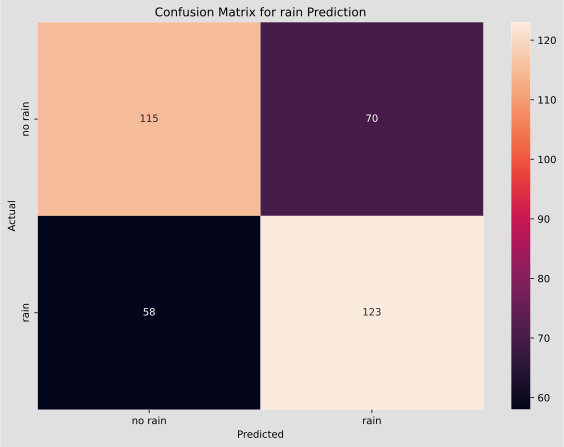

In [80]:
actual = []
predicted = []

for idx, row in test.iterrows():
    actual.append(row['rain'])
    predicted.append(predict_precipitation(bn, row))
    
state_to_num = {'no rain':0, 'rain':1}
actual_num = [state_to_num[state] for state in actual]

cm = confusion_matrix(actual_num, predicted)

labels = ['no rain', 'rain']
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for rain Prediction')
plt.savefig("./cm.png")
plt.show()

In [86]:
accuracy_score(actual_num, predicted)

0.6502732240437158

# Inference

In [81]:
ie=gum.LazyPropagation(bn)

In [82]:
def categorize_value(value, quantiles, labels):
    category = pd.cut([value], bins=quantiles, labels=labels, include_lowest=True)
    return category[0]

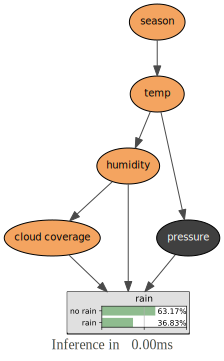

In [83]:
quantiles = bn_df['humidity'].quantile([0, 0.33, 0.66, 1.0])
labels = ['low', 'medium', 'high']

irl_temp = 19
irl_cloud_coverage = 40
irl_humidity = 71
season = "Spring"

transformed_temp = "high" if irl_temp >= bn_df["temp"].mean() else "low"
transformed_cloud_coverage = "high" if irl_cloud_coverage >= 85 else "low"
transformed_humidity =  categorize_value(irl_humidity, quantiles, labels)

gnb.showInference(bn,evs={"temp":transformed_temp ,"cloud coverage":transformed_cloud_coverage ,"humidity":transformed_humidity, "season":season}
                  ,targets={"rain"})

20% chance of rain predicted on the website

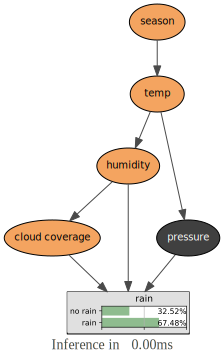

In [84]:
quantiles = bn_df['humidity'].quantile([0, 0.33, 0.66, 1.0])
labels = ['low', 'medium', 'high']

irl_temp = 18
irl_cloud_coverage = 98
irl_humidity = 75
season = "Spring"

transformed_temp = "high" if irl_temp >= bn_df["temp"].mean() else "low"
transformed_cloud_coverage = "high" if irl_cloud_coverage >= 85 else "low"
transformed_humidity =  categorize_value(irl_humidity, quantiles, labels)

gnb.showInference(bn,evs={"temp":transformed_temp ,"cloud coverage":transformed_cloud_coverage , "humidity":transformed_humidity, "season":season}
                  ,targets={"rain"})

93% rain predicted on the website